

##Import data


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:09<00:00, 2806147.60it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 169249.79it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3177573.60it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22776663.49it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



##Zad 1

In [ ]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input: 28x28 image, Output: 128 features
        self.fc2 = nn.Linear(128, 64)  # Hidden layer with 64 neurons
        self.fc3 = nn.Linear(64, 10)  # Output layer: 10 classes for classification

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image to a vector of size 28*28
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation at the output layer (will use CrossEntropyLoss which applies softmax)
        return x


model = FashionMNISTModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, criterion, optimizer, num_epochs=8):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


train_model(model, train_loader, criterion, optimizer, num_epochs=8)


def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the model on the test set: {100 * correct / total:.2f}%")


# Evaluate the model
test_model(model, test_loader)

Epoch [1/8], Loss: 0.5177
Epoch [2/8], Loss: 0.3820
Epoch [3/8], Loss: 0.3412
Epoch [4/8], Loss: 0.3158
Epoch [5/8], Loss: 0.2974
Epoch [6/8], Loss: 0.2803
Epoch [7/8], Loss: 0.2690
Epoch [8/8], Loss: 0.2569
Accuracy of the model on the test set: 88.13%


##Zad 2

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Input layer to hidden layer (encoding size: 128)
            nn.ReLU(),
            nn.Linear(128, 64),  # Compress to 64 dimensions
            nn.ReLU(),
            nn.Linear(64, 32),  # Compress to 32 dimensions (latent space)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),  # Expand back to 64 dimensions
            nn.ReLU(),
            nn.Linear(64, 128),  # Expand to 128 dimensions
            nn.ReLU(),
            nn.Linear(128, 28 * 28),  # Reconstruct to original size (28*28)
            nn.Sigmoid(),  # Sigmoid activation to get values between 0 and 1
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image to a vector
        encoded = self.encoder(x)  # Pass through encoder
        decoded = self.decoder(encoded)  # Pass through decoder
        decoded = decoded.view(-1, 1, 28, 28)  # Reshape back to image dimensions
        return decoded


# Instantiate the model
model = Autoencoder()

# 3. Define the loss function and optimizer
loss_function = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:  # We don't need the labels for the autoencoder
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = loss_function(outputs, images)  # Compute loss (reconstruction error)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


# Train the autoencoder for 5 epochs
train_autoencoder(model, train_loader, loss_function, optimizer, num_epochs=5)

Epoch [1/5], Loss: 0.6321
Epoch [2/5], Loss: 0.6041
Epoch [3/5], Loss: 0.5998
Epoch [4/5], Loss: 0.5974
Epoch [5/5], Loss: 0.5958


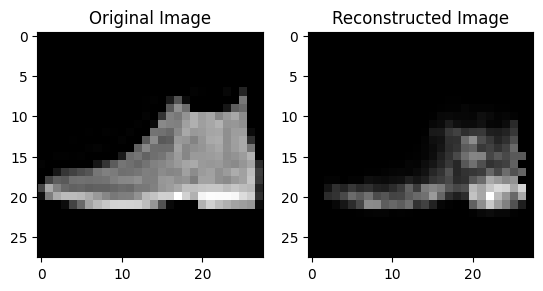

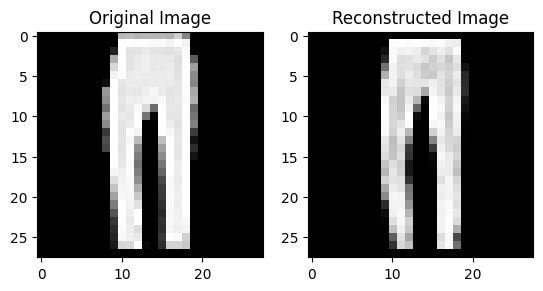

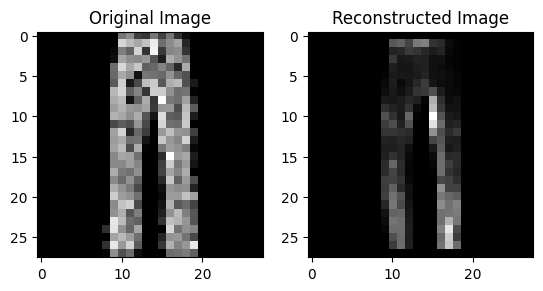

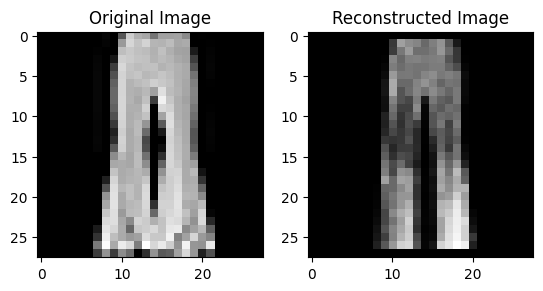

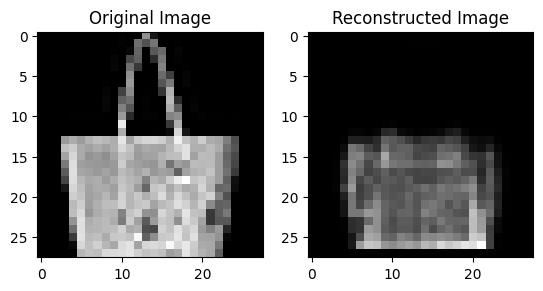

In [19]:
import matplotlib.pyplot as plt


def visualize_reconstructions(model, test_loader):
    model.eval()
    with torch.no_grad():  # No need to track gradients during evaluation
        cnt = 0
        for images, _ in test_loader:
            cnt += 1
            outputs = model(images)  # Forward pass
            # Display the first image in the batch and its reconstruction
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(images[0].view(28, 28).cpu().numpy(), cmap="gray")
            axes[0].set_title("Original Image")
            axes[1].imshow(outputs[0].view(28, 28).cpu().numpy(), cmap="gray")
            axes[1].set_title("Reconstructed Image")
            plt.show()
            if cnt > 4:
                break  # Just visualize the first batch


# Visualize the reconstruction from the test set
visualize_reconstructions(model, test_loader)